In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2

In [8]:
# notebook parameters
n_dimensions = 2
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1
rng = np.random.default_rng(random_seed)
tf.random.set_seed(random_seed)

n_layers = 1
n_dim_per_layer = 2**8

#ACTIVATIONS = tf.nn.elu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 2**3
LEARNING_RATE = 1e-3
N_EPOCHS = 200

# only diagonal diffusivity matrix
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [9]:
# generate training data
def f_1(x):
    A = -1.5
    B = np.array([[4], [0]])
    C = np.array([[0], [0]])
    D = np.array([[-2], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = -1.5
    B = np.array([[0], [4]])
    C = np.array([[0], [0]])
    D = np.array([[0], [-2]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x)]))
    return drift


def sigma_11(x):
    A = 0.5  
    B = np.array([[0.05], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = 0
    B = np.array([[0], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = 0.5
    B = np.array([[0], [0.05]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusion(x):
    diffusion = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x)], [sigma_12(x), sigma_22(x)]])))
    return diffusion


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2], [-2, 2]])

x_data, y_data, _ = sample_data(true_drift_diffusion, step_size,
                             n_pts, n_subsample, rng, xlim)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 2)


In [10]:
# train model
No_of_tests = 1
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
#training_time = np.zeros(No_of_tests)
#val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    # define model
    tf.random.set_seed(i)
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax())
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()
    
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]




training for 200 epochs with 9000 data points, validating with 1000


In [28]:
# for i in range(No_of_tests):
#     moving_avg = np.zeros(N_EPOCHS)
#     min_moving_avg = float('inf')
#     moving_avg_len = 40
#     min_index = 0
#     break_iterations = 40
#     for j in range(N_EPOCHS):
#         if j < moving_avg_len:
#             moving_avg[j] = np.mean(val_losses[i,:j+1])
#         else:
#             moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

#         if moving_avg[j] < min_moving_avg:
#             min_moving_avg = moving_avg[j]
#             min_index = j

#         if min_index + break_iterations < j:
#             break

#     val_loss_array = val_losses[i,:j]
#     val_loss_min_index = np.argmin(val_loss_array)
#     training_time[i] = cumulative_times[i,val_loss_min_index]
#     val_loss[i] = val_losses[i,val_loss_min_index]

alpha = 0.1  # EWMA smoothing factor
plateau_check_epochs = 10
plateau_threshold = 1e-3  # Flatness threshold
epsilon = 1e-3  # For first-time-within-epsilon criterion
break_patience = 40  # Max allowed steps with no improvement

for i in range(No_of_tests):
    ema = np.zeros(N_EPOCHS)
    ema[0] = val_losses[i, 0]
    best_ema = ema[0]
    best_epoch = 0

    for j in range(1, N_EPOCHS):
        ema[j] = alpha * val_losses[i, j] + (1 - alpha) * ema[j - 1]

        if ema[j] < best_ema:
            best_ema = ema[j]
            best_epoch = j

        if j - best_epoch >= break_patience:
            break  # Early stopping based on EWMA flatness

    # j is now the stopping epoch
    losses_seen = val_losses[i, :j+1]
    times_seen = cumulative_times[i, :j+1]

    # Pick first time within epsilon of global min seen before stopping
    global_min = np.min(losses_seen)
    within_eps_mask = losses_seen <= global_min + epsilon

    if np.any(within_eps_mask):
        first_within_eps = np.argmax(within_eps_mask)
    else:
        first_within_eps = np.argmin(losses_seen)

    # Optional: additional flatness check after best_epoch
    plateau_end = min(best_epoch + plateau_check_epochs, len(losses_seen))
    plateau_segment = losses_seen[best_epoch:plateau_end]
    
    if len(plateau_segment) >= 2:
        if np.max(np.abs(np.diff(plateau_segment))) < plateau_threshold:
            final_index = best_epoch
        else:
            final_index = first_within_eps
    else:
        # Not enough points to check plateau, fall back to first_within_eps
        final_index = first_within_eps

    val_loss[i] = losses_seen[final_index]
    training_time[i] = times_seen[final_index]


C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\matplotlib\axes\_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
C:\Users\Admin\Documents\work\kaust\wor

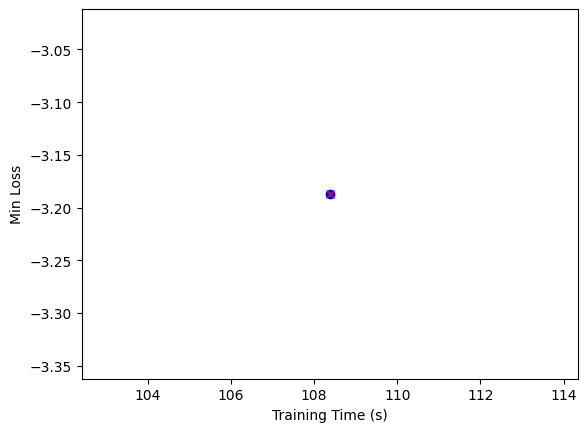

Mean Min Loss:  -3.1870260753594275
Mean Training Time:  108.37622666358948 s
figures_per_row 2


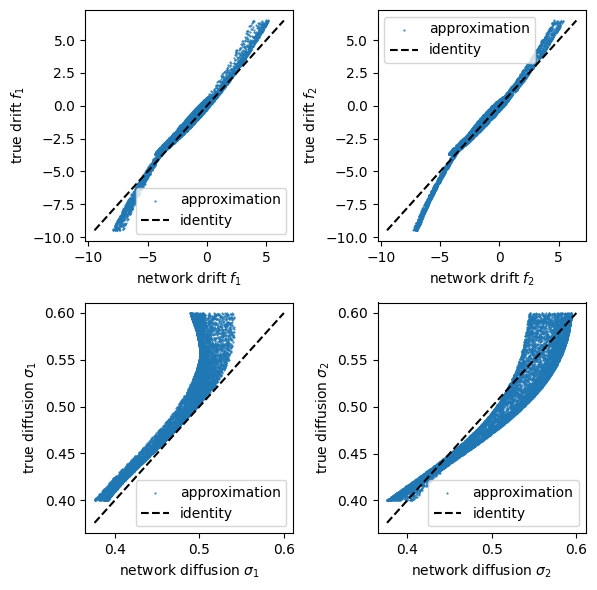

In [29]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 0:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusion, x_data, save=False)

# time = 100*step_size
# PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
# PR.plot_histogram(sde_i.drift_diffusivity, step_size, time, rng, xlim, name='ARFF', save=False)


In [24]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 256)          768         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 256)          768         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 2)            514         ['GP_mean_hidden_0[0][0]']       
                                                                                

C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Admin\Documents\work\kaust\work\ARFF SDE project\code\environments\SDE_ARFF_CPU\lib\site-packages\matplotlib\axes\_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
C:\Users\Admin\Documents\work\kaust\wor

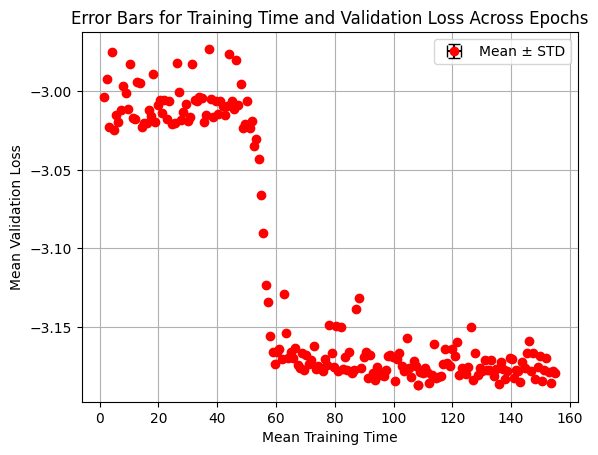

In [25]:
# Initialize arrays to store results
mean_training_time = np.zeros(N_EPOCHS)
mean_val_loss = np.zeros(N_EPOCHS)
std_training_time_above = np.zeros(N_EPOCHS)
std_training_time_below = np.zeros(N_EPOCHS)
std_val_loss_above = np.zeros(N_EPOCHS)
std_val_loss_below = np.zeros(N_EPOCHS)

# Iterate over epochs
for epoch in range(N_EPOCHS):
    training_time = cumulative_times[:, epoch]
    val_loss = val_losses[:, epoch]

    # Calculate mean
    mean_training_time[epoch] = np.mean(training_time)
    mean_val_loss[epoch] = np.mean(val_loss)

    # Calculate deviations for training_time
    training_time_above = training_time[training_time > mean_training_time[epoch]] - mean_training_time[epoch]
    training_time_below = mean_training_time[epoch] - training_time[training_time < mean_training_time[epoch]]
    std_training_time_above[epoch] = np.std(np.concatenate((training_time_above, -training_time_above)))
    std_training_time_below[epoch] = np.std(np.concatenate((training_time_below, -training_time_below)))

    # Calculate deviations for val_loss
    val_loss_above = val_loss[val_loss > mean_val_loss[epoch]] - mean_val_loss[epoch]
    val_loss_below = mean_val_loss[epoch] - val_loss[val_loss < mean_val_loss[epoch]]
    std_val_loss_above[epoch] = np.std(np.concatenate((val_loss_above, -val_loss_above)))
    std_val_loss_below[epoch] = np.std(np.concatenate((val_loss_below, -val_loss_below)))

plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[std_training_time_below, std_training_time_above],  # Non-symmetrical x error
    yerr=[std_val_loss_below, std_val_loss_above],  # Non-symmetrical y error
    fmt='o', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean Â± STD'
)

plt.xlabel('Mean Training Time')
plt.ylabel('Mean Validation Loss')
plt.title('Error Bars for Training Time and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)

In [14]:
# export data
data = pd.DataFrame({
    "cum_time": mean_training_time,
    "loss": mean_val_loss,
    "std_training_time_above": std_training_time_above,
    "std_training_time_below": std_training_time_below,
    "std_val_loss_above": std_val_loss_above,
    "std_val_loss_below": std_val_loss_below
})

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "example3 - 2d sde-cubic data.csv")
# data.to_csv(output_path, index=False)